# **Vision Sandbox**

Overarching notebook for exploring different facets of 3D vision topics in math and computer science

*Set up and imports*

In [3]:
%load_ext autoreload
%autoreload 2

In [10]:
import cv2
import matplotlib.pyplot as plt

## Module 1: Image Stitching
In this module, I aim to employ homography and feature matching to stitch images together

In [30]:
room1 = cv2.imread(rf"Data\room1.jpeg")
room2 = cv2.imread(rf"Data\room2.jpeg")

room1 = cv2.resize(room1, (806,605))
room2 = cv2.resize(room2, (806,605))

(np.float64(-0.5), np.float64(805.5), np.float64(604.5), np.float64(-0.5))

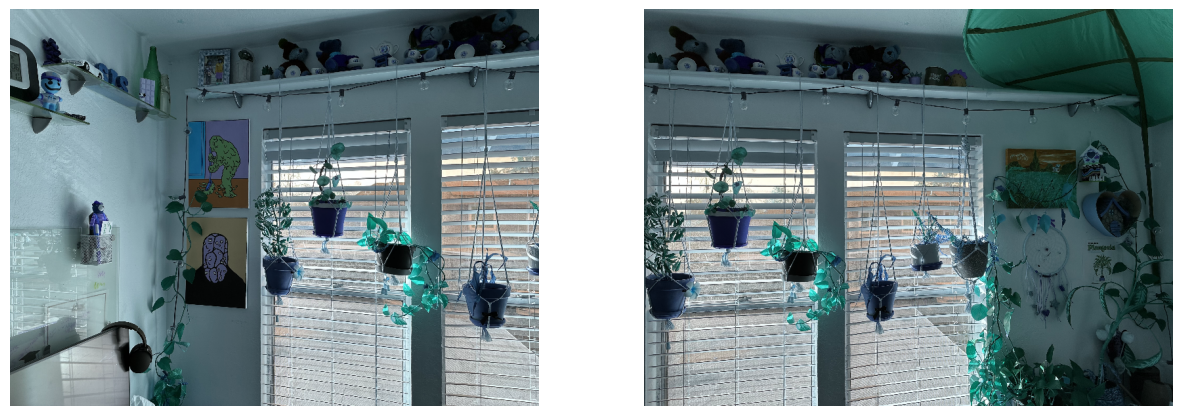

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(room1)
ax[1].imshow(room2)

ax[0].axis('off')
ax[1].axis('off')

Now that the images have been read, we need to extract features from both! 

To do so, we'll use ORB, a feature extractor that is rotation invariant. This means regardless of orientation, ORB will still be able to match the key points between the images!

In [32]:
# Display information on how to use ORB
orb = cv2.ORB_create()
help(orb)


Help on ORB in module cv2 object:

class ORB(Feature2D)
 |  Method resolution order:
 |      ORB
 |      Feature2D
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  getDefaultName(...)
 |      getDefaultName() -> retval
 |      .
 |  
 |  getEdgeThreshold(...)
 |      getEdgeThreshold() -> retval
 |      .
 |  
 |  getFastThreshold(...)
 |      getFastThreshold() -> retval
 |      .
 |  
 |  getFirstLevel(...)
 |      getFirstLevel() -> retval
 |      .
 |  
 |  getMaxFeatures(...)
 |      getMaxFeatures() -> retval
 |      .
 |  
 |  getNLevels(...)
 |      getNLevels() -> retval
 |      .
 |  
 |  getPatchSize(...)
 |      getPatchSize() -> retval
 |      .
 |  
 |  getScaleFactor(...)
 |      getScaleFactor() -> retval
 |      .
 |  
 |  getScoreType(...)
 |      getScoreType() -> retval
 |      .
 |  
 |  getWTA_K(...)
 |      getWTA_K() -> retval
 |      .
 |  
 |  setEdgeThreshold(...)
 |      setEdgeThreshold(ed

In [33]:
help(orb.detectAndCompute)

Help on built-in function detectAndCompute:

detectAndCompute(...) method of cv2.ORB instance
    detectAndCompute(image, mask[, descriptors[, useProvidedKeypoints]]) -> keypoints, descriptors
    .   Detects keypoints and computes the descriptors



(np.float64(-0.5), np.float64(805.5), np.float64(604.5), np.float64(-0.5))

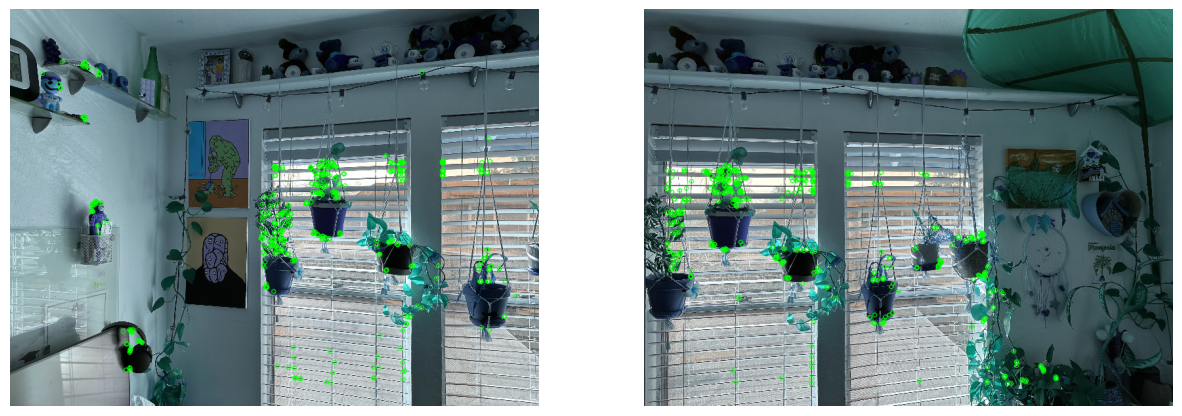

In [34]:
keyPts1, desc1 = orb.detectAndCompute(room1, None)
keyPts2, desc2 = orb.detectAndCompute(room2, None)

room1_feats = cv2.drawKeypoints(room1, keyPts1, None, color=(0,255,0))
room2_feats = cv2.drawKeypoints(room2, keyPts2, None, color=(0,255,0))

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(room1_feats)
ax[1].imshow(room2_feats)

ax[0].axis('off')
ax[1].axis('off')

Each of the results here has many options for key points, some of which will be good matches. At minimum we want to see 4 matches. This is because the homography matrix has 8 degrees of freedom and each correspondence solves for 2 constraints. ($8 DoFs / 2 values = 4 matches$)
\
\
\
That means our next step is simply finding the matches! Which we'll do using Brute-Force Matcher :)

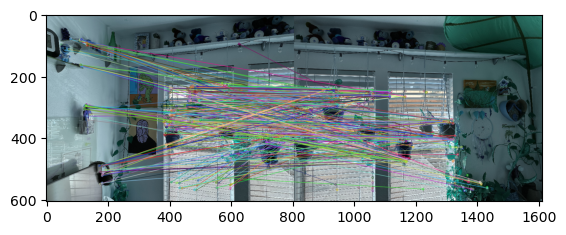

In [47]:
''' 
=>  In this situation we'll opt to use hamming distance instead of the typical L2 
    distance as the descriptors we compare are stored using binary strings.
'''
matcher = cv2.BFMatcher(cv2.NORM_HAMMING) 

matches = matcher.match(desc1, desc2)
rendered_matches = cv2.drawMatches(room1, keyPts1, room2, keyPts2, matches, None)
plt.imshow(rendered_matches)

After the matching, it appears like there's some matching that shouldn't be taking place. Of course, it's entirely possible that the features too similar to discern by BFMatcher but hopefully we can minimize the damage caused by that.
\
\
\
From researching further about BFMatcher, the results are not returned in a sorted order. To amend this problem, we can take the shortest distances in the matching as those will give us the best points of reference to stitch from.

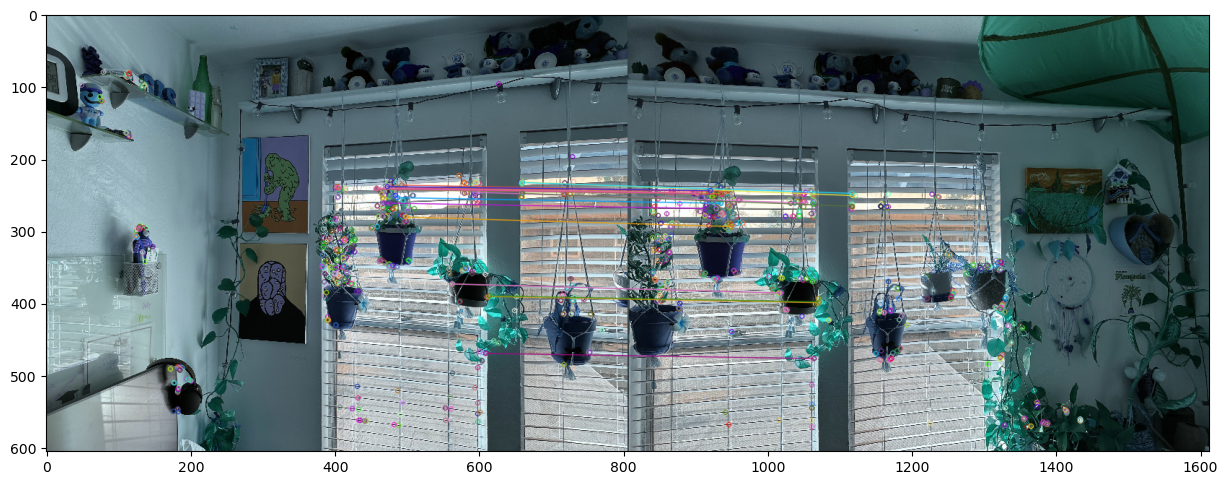

In [53]:
matches = sorted(matches, key=lambda x: x.distance)
n = 20

# With the matches sorted by distance, time to re-draw the top n results
top_n_rendered_matches = cv2.drawMatches(room1, keyPts1, room2, keyPts2, matches[:n], None)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(top_n_rendered_matches)

There seem to be a lot more than 20 good matches but if the stitching goes poorly, I can change the threshold to n matches.

The next step seems to be, find the n matches in their respective images

In [55]:
print(f'dist to match: {matches[0].distance} \nimgIdx: {matches[0].imgIdx} \nqueryIdx: {matches[0].queryIdx} \ntrainIdx: {matches[0].trainIdx}')

dist to match: 16.0 
imgIdx: 0 
queryIdx: 276 
trainIdx: 291


(np.float64(-0.5), np.float64(805.5), np.float64(604.5), np.float64(-0.5))

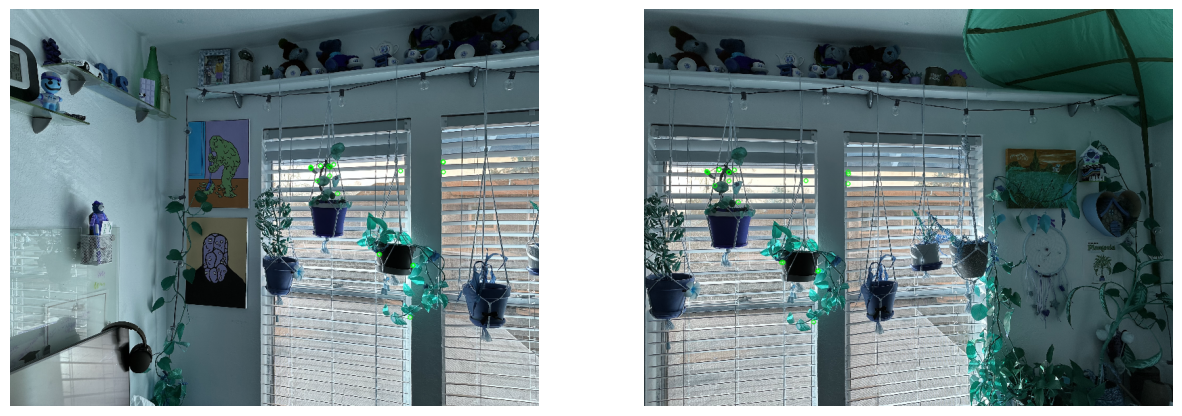

In [60]:
top_n_kps_1 = []
top_n_kps_2 = []
for i in range(n):
    top_n_kps_1.append(keyPts1[matches[i].queryIdx])
    top_n_kps_2.append(keyPts2[matches[i].trainIdx])

best_room1 = cv2.drawKeypoints(room1, tuple(top_n_kps_1), None, color=(0,255,0))
best_room2 = cv2.drawKeypoints(room2, tuple(top_n_kps_2), None, color=(0,255,0))


fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(best_room1)
ax[1].imshow(best_room2)

ax[0].axis('off')
ax[1].axis('off')